# 데이터 로드

## 기본 라이브러리 로드

In [5]:
# !pip install mxnet
# !pip install gluonnlp pandas tqdm
# !pip install sentencepiece
# !pip install transformers==3.0.2
# !pip install torch

  Using cached transformers-3.0.2-py3-none-any.whl (769 kB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.9.2
    Uninstalling transformers-4.9.2:
      Successfully uninstalled transformers-4.9.2


In [1]:
from transformers import BertTokenizer, TFBertModel, AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

import tensorflow as tf

import numpy as np
from tqdm import tqdm, tqdm_notebook

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

## BertTokenizer 로드

In [2]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

## 데이터 로드

In [3]:
text_data = pd.read_excel('train_data7.xlsx', engine='openpyxl')
val_data = pd.read_excel('val_data2.xlsx', engine='openpyxl')

## 데이터 기본 정보 확인

In [4]:
print(len(val_data), type(val_data))
print(len(text_data), type(text_data))

5130 <class 'pandas.core.frame.DataFrame'>
69218 <class 'pandas.core.frame.DataFrame'>


In [5]:
temp_label = text_data['label'].value_counts()
print(temp_label, type(temp_label), temp_label.index)

대인관계            7535
진로, 취업, 직장      4114
연애, 결혼, 출산      3866
건강, 죽음          3230
재정              3104
대인관계(부부, 자녀)    2811
직장, 업무 스트레스     2722
재정, 은퇴, 노후준비    2574
건강              2531
학업 및 진로         2400
학교폭력/따돌림        2316
가족관계            2212
Name: label, dtype: int64 <class 'pandas.core.series.Series'> Index(['대인관계', '진로, 취업, 직장', '연애, 결혼, 출산', '건강, 죽음', '재정', '대인관계(부부, 자녀)',
       '직장, 업무 스트레스', '재정, 은퇴, 노후준비', '건강', '학업 및 진로', '학교폭력/따돌림', '가족관계'],
      dtype='object')


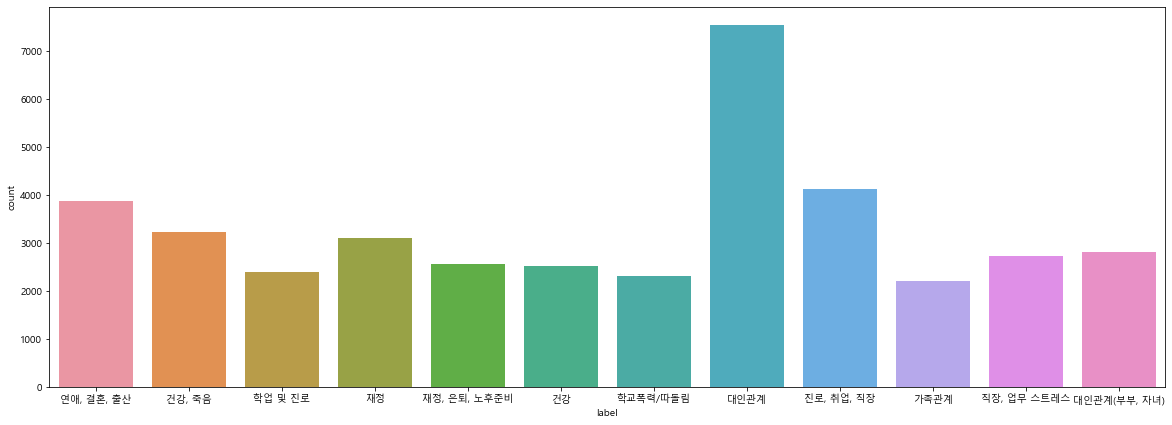

In [6]:
plt.rcParams['font.family'] = 'Malgun Gothic'

plt.figure(figsize = (20,7))
sns.countplot(data = text_data , x = 'label' )
plt.show()

## 데이터 전처리
label한글로 되어있는 데이터를 12개의 범주로 변경한다

In [7]:
from sklearn.preprocessing import LabelEncoder

label_data = text_data['label']
label_data_val = val_data['label']


encoder = LabelEncoder()

encoder.fit(label_data)

labels = pd.DataFrame(encoder.transform(label_data))
labels_val = pd.DataFrame(encoder.transform(label_data_val))

In [8]:
text_data['label2'] = labels
val_data['label2'] = labels_val

In [9]:
total_labels = list(encoder.inverse_transform([0,1,2,3,4,5,6,7,8,9,10,11]))
print(total_labels)

['가족관계', '건강', '건강, 죽음', '대인관계', '대인관계(부부, 자녀)', '연애, 결혼, 출산', '재정', '재정, 은퇴, 노후준비', '직장, 업무 스트레스', '진로, 취업, 직장', '학교폭력/따돌림', '학업 및 진로']


In [10]:
print(text_data['label2'].unique() , '\n',  val_data['label2'].unique() )

[ 5  2 11  6  7  1 10  3  9  0  8  4 12] 
 [ 9  0 10  7  4  8 11  2  3  5  6  1 12]


# 모델 생성

## Tokenizer

### tokenizer 테스트하기

In [11]:
# 스페셜 토큰
#print(tokenizer.all_special_tokens, "\n", tokenizer.all_special_ids)

# 토크나이저 테스트하기
kor_encode = tokenizer.encode("아 결국 친구한테 빌려준 돈을 떼이게 생겼어. 급전이 필요하다고 부탁해서 여러차례 빌려준게 벌써 천 만원이 넘는데 십 년이 지나도 갚을 생각을 안하는것 같아 연락을 했더니 전화번호도 바꾸고 잠적해버렸네. 나뿐만 아니고 이 친구한테 당한 사람이 한둘이 아냐. 아주 상습범이더구만. ")
#eng_encode = tokenizer.encode("Hello world")
print(kor_encode)
kor_decode = tokenizer.decode(kor_encode)
#eng_decode = tokenizer.decode(eng_encode)

print(len(kor_encode))
#print(eng_encode)
print(kor_decode)
#print(eng_decode)

[101, 9519, 50342, 9781, 17196, 11102, 119351, 9382, 26737, 54867, 9089, 10622, 9143, 10739, 14153, 9420, 118637, 12965, 119, 8929, 16617, 10739, 9949, 48549, 32679, 11664, 9365, 119335, 70146, 30085, 23466, 58762, 9382, 26737, 54867, 14153, 9339, 73131, 9746, 9248, 73295, 9008, 41850, 9492, 9018, 10739, 9706, 16439, 12092, 8856, 10622, 9420, 66540, 10622, 9521, 12178, 118627, 8855, 16985, 9568, 107693, 10622, 9965, 54141, 25503, 9665, 18227, 35465, 20309, 12092, 9318, 118694, 11664, 9655, 14801, 14523, 41605, 118881, 77884, 119, 8982, 119020, 19105, 9519, 25503, 11664, 9638, 9781, 17196, 11102, 119351, 9067, 11102, 97802, 9954, 118805, 10739, 9519, 118728, 119, 9519, 16323, 9414, 119081, 108056, 10739, 54141, 17196, 19105, 119, 102]
111
[CLS] 아 결국 친구한테 빌려준 돈을 떼이게 생겼어. 급전이 필요하다고 부탁해서 여러차례 빌려준게 벌써 천 만원이 넘는데 십 년이 지나도 갚을 생각을 안하는것 같아 연락을 했더니 전화번호도 바꾸고 잠적해버렸네. 나뿐만 아니고 이 친구한테 당한 사람이 한둘이 아냐. 아주 상습범이더구만. [SEP]


### tokenizer 생성

In [12]:
# train_data = train_data[:1000] # for test
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN = 150 # EDA에서 추출된 Max Length 

In [13]:
def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True ,  # Construct attn. masks.
        truncation=True
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

### tokenizer에 데이터 입력하여 Bert 형태 데이터 생성

In [14]:
input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sent, train_label in tqdm(zip(text_data["text"], text_data["label2"]), total=len(text_data)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)

    except Exception as e:
        print(e)
        print(train_sent)
        pass

train_sentence_input_ids = np.array(input_ids, dtype=int)
train_sentence_attention_masks = np.array(attention_masks, dtype=int)
train_sentence_type_ids = np.array(token_type_ids, dtype=int)
train_sentence_inputs = (train_sentence_input_ids, train_sentence_attention_masks, train_sentence_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("# sents: {}, # labels: {}".format(len(train_sentence_input_ids), len(train_data_labels)))

 58%|██████████████████████████████████████████▊                               | 40075/69218 [00:23<00:09, 3009.96it/s]

Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of inte

 59%|███████████████████████████████████████████▌                              | 40744/69218 [00:23<00:09, 2902.33it/s]

nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of 

 60%|████████████████████████████████████████████                              | 41215/69218 [00:23<00:08, 3400.28it/s]


nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of

 61%|█████████████████████████████████████████████                             | 42145/69218 [00:24<00:07, 3857.48it/s]


Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of int

 62%|██████████████████████████████████████████████                            | 43142/69218 [00:24<00:06, 4345.75it/s]

nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of 

 63%|██████████████████████████████████████████████▌                           | 43581/69218 [00:24<00:06, 4249.72it/s]

Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of inte

 64%|███████████████████████████████████████████████▋                          | 44639/69218 [00:24<00:05, 4195.06it/s]


Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of int

 66%|████████████████████████████████████████████████▋                         | 45599/69218 [00:24<00:05, 4419.49it/s]

nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of 

 67%|█████████████████████████████████████████████████▏                        | 46045/69218 [00:25<00:05, 4221.94it/s]

nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of 

 68%|██████████████████████████████████████████████████▏                       | 46937/69218 [00:25<00:05, 4170.99it/s]

nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of 

 69%|███████████████████████████████████████████████████                       | 47774/69218 [00:25<00:05, 3779.06it/s]


nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of

 70%|████████████████████████████████████████████████████                      | 48752/69218 [00:25<00:04, 4245.58it/s]

Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of inte

 71%|████████████████████████████████████████████████████▌                     | 49219/69218 [00:25<00:04, 4350.16it/s]


Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of int

 73%|█████████████████████████████████████████████████████▋                    | 50225/69218 [00:25<00:04, 4546.99it/s]

nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of 

 74%|██████████████████████████████████████████████████████▊                   | 51234/69218 [00:26<00:03, 4726.58it/s]

nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of 

 75%|███████████████████████████████████████████████████████▎                  | 51710/69218 [00:26<00:03, 4472.85it/s]

nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of 

 76%|████████████████████████████████████████████████████████▎                 | 52703/69218 [00:26<00:03, 4509.00it/s]

nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of 

 78%|█████████████████████████████████████████████████████████▍                | 53751/69218 [00:26<00:03, 4503.88it/s]

Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of inte

 79%|██████████████████████████████████████████████████████████▌               | 54754/69218 [00:26<00:03, 4760.33it/s]

nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of 

 80%|███████████████████████████████████████████████████████████▏              | 55326/69218 [00:27<00:02, 4975.68it/s]

nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of 

 81%|████████████████████████████████████████████████████████████▏             | 56312/69218 [00:27<00:02, 4573.92it/s]

Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of inte

 83%|█████████████████████████████████████████████████████████████▏            | 57241/69218 [00:27<00:02, 4474.72it/s]

Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of inte

 84%|██████████████████████████████████████████████████████████████▏           | 58197/69218 [00:27<00:02, 4414.62it/s]


Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of int

 85%|██████████████████████████████████████████████████████████████▋           | 58645/69218 [00:27<00:02, 4143.67it/s]


nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of

 86%|███████████████████████████████████████████████████████████████▊          | 59667/69218 [00:28<00:02, 4525.78it/s]


nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of

 88%|████████████████████████████████████████████████████████████████▊         | 60593/69218 [00:28<00:01, 4546.23it/s]


Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of int

 89%|█████████████████████████████████████████████████████████████████▊        | 61568/69218 [00:28<00:01, 4675.11it/s]


Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of int

 90%|██████████████████████████████████████████████████████████████████▉       | 62595/69218 [00:28<00:01, 4882.50it/s]

Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of inte

 91%|███████████████████████████████████████████████████████████████████▌      | 63139/69218 [00:28<00:01, 4998.77it/s]

nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of 

 93%|████████████████████████████████████████████████████████████████████▌     | 64163/69218 [00:29<00:01, 4430.09it/s]


nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of

 93%|█████████████████████████████████████████████████████████████████████     | 64626/69218 [00:29<00:01, 4275.34it/s]

nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of 

 95%|██████████████████████████████████████████████████████████████████████    | 65516/69218 [00:29<00:00, 4144.90it/s]

nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of 

 96%|███████████████████████████████████████████████████████████████████████▏  | 66547/69218 [00:29<00:00, 4552.18it/s]

Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of inte

 97%|███████████████████████████████████████████████████████████████████████▋  | 67009/69218 [00:29<00:00, 3959.68it/s]

Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of inte

 98%|████████████████████████████████████████████████████████████████████████▋ | 68027/69218 [00:29<00:00, 4424.91it/s]


Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of int

 99%|█████████████████████████████████████████████████████████████████████████▎| 68583/69218 [00:30<00:00, 4560.64it/s]


nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of

100%|██████████████████████████████████████████████████████████████████████████| 69218/69218 [00:30<00:00, 2288.24it/s]

Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of inte

In [15]:
train_sentence_input_ids
train_sentence_attention_masks 
train_sentence_type_ids 
train_sentence_inputs

(array([[   101,   9519,  31605, ...,      0,      0,      0],
        [   101,   9067, 118750, ...,      0,      0,      0],
        [   101,   8888,  55511, ...,      0,      0,      0],
        ...,
        [   101,   9553,  23811, ...,      0,      0,      0],
        [   101,   9638,  82838, ...,      0,      0,      0],
        [   101,   9781,  17196, ...,      0,      0,      0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [16]:
print(train_sentence_input_ids.shape,
train_sentence_attention_masks.shape,
train_sentence_type_ids.shape,
train_sentence_inputs[0].shape,
train_sentence_inputs[1].shape,
train_sentence_inputs[2].shape)

(39415, 150) (39415, 150) (39415, 150) (39415, 150) (39415, 150) (39415, 150)


### tokenizer 테스트해보기

In [71]:
print(train_sentence_input_ids[0], text_data["text"][0])

[  101  9519 31605 11287  9113 48446 12965  9768 21386 17594 37909 12424
  9670 89523  9487 10739  8982   119   102     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0] 아내가 드디어 출산하게 되어서 정말 신이 나.


In [72]:
print(train_sentence_attention_masks[0], text_data["text"][0])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0] 아내가 드디어 출산하게 되어서 정말 신이 나.


In [73]:
print(train_sentence_type_ids[0], text_data["text"][0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0] 아내가 드디어 출산하게 되어서 정말 신이 나.


In [92]:
 tokenizer.decode(train_sentence_input_ids[0])

'[CLS] 아내가 드디어 출산하게 되어서 정말 신이 나. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

## BertClassifier 모델 생성

In [25]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier") #(2,) 샘플이 어떤것이든간에 긍정인지 아닌지만나옴(H,)
           
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

In [26]:
cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=12)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


In [27]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# fit

In [ ]:
import os
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

DATA_IN_PATH = 'data_text/IN'
DATA_OUT_PATH = "data_text/OUT"

model_name = "tf2_bert_text"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights_text.h5')
print(checkpoint_path)
checkpoint_dir = os.path.dirname(checkpoint_path)
print(checkpoint_dir)
# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))


cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작

#history = cls_model.fit(train_sentence_inputs, train_data_labels, epochs=5, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch

#print(history.history)
#print(cls_model.summary())

In [37]:
# 이미 학습된 웨이트를 가져오기 
cls_model.load_weights('project/weight2.h5')

In [38]:
print(cls_model.weights[0].shape,
cls_model.weights[1].shape,
cls_model.weights[2].shape,
cls_model.weights[3].shape,
cls_model.weights[4].shape     
     )

(119547, 768) (512, 768) (2, 768) (768,) (768,)


# evaluate

## Tokenizer

In [31]:
text_data

input_ids = []
attention_masks = []
token_type_ids = []
val_data_labels = []

for val_sent, val_label in tqdm(zip(val_data["text"], val_data["label2"]), total=len(val_data)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(val_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        val_data_labels.append(val_label)

    except Exception as e:
        print(e)
        print(val_sent)
        pass

val_sentence_input_ids = np.array(input_ids, dtype=int)
val_sentence_attention_masks = np.array(attention_masks, dtype=int)
val_sentence_type_ids = np.array(token_type_ids, dtype=int)
val_sentence_inputs = (val_sentence_input_ids, val_sentence_attention_masks, val_sentence_type_ids)

val_data_labels = np.asarray(val_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("# sents: {}, # labels: {}".format(len( val_sentence_input_ids), len( val_data_labels)))

100%|████████████████████████████████████████████████████████████████████████████| 5130/5130 [00:03<00:00, 1646.57it/s]


Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
nan
Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of inte

In [94]:
print(val_sentence_input_ids[0], val_data["text"][0])

[   101   9599 119229   9365  39420 108578  11882  47058   9365 118824
  80579    119    102      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      

In [95]:
print(val_sentence_attention_masks[0], val_data["text"][0])

[1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0] 요즘 부모님과 많이 부딪혀.


In [96]:
print(val_sentence_type_ids[0], val_data["text"][0])


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0] 요즘 부모님과 많이 부딪혀.


## 평가

In [40]:
results = cls_model.evaluate(val_sentence_inputs, val_data_labels, batch_size=100)
print("test loss, test acc: ", results)

52/52 [==============================] - 1503s 29s/step - loss: 1.0927 - accuracy: 0.6441
test loss, test acc:  [1.0927178859710693, 0.6441308856010437]


In [41]:
cls_model.summary()

Model: "tf_bert_classifier_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tf_bert_model_1 (TFBertModel multiple                  177853440 
_________________________________________________________________
dropout_75 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  9228      
Total params: 177,862,668
Trainable params: 177,862,668
Non-trainable params: 0
_________________________________________________________________


# 예측(predict)

In [44]:

MAX_LEN = 150 # EDA에서 추출된 Max Length
input_id , attention_mask, token_type_id = bert_tokenizer("친구들이랑 화해하고 싶어",MAX_LEN)
print(input_id)
print(attention_mask)
print(token_type_id)

x= [np.array([input_id]),np.array([token_type_id]) ,np.array([attention_mask]) ]
results = cls_model.predict(x)
results = np.argmax(results)
print(results)

list(encoder.inverse_transform([results]))

[101, 9781, 17196, 20173, 62200, 9993, 14523, 12453, 9495, 12965, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

['대인관계']

In [45]:
total_labels = list(encoder.inverse_transform([0,1,2,3,4,5,6,7,8,9,10,11]))
print(total_labels)

['가족관계', '건강', '건강, 죽음', '대인관계', '대인관계(부부, 자녀)', '연애, 결혼, 출산', '재정', '재정, 은퇴, 노후준비', '직장, 업무 스트레스', '진로, 취업, 직장', '학교폭력/따돌림', '학업 및 진로']
